In [113]:
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor


In [114]:
pwd

'e:\\solar-power-forecast-project\\notebooks'

In [115]:
data_path = Path.cwd().parent / "data" / "raw" / "Plant_1_Generation_Data.csv"
print(data_path)

e:\solar-power-forecast-project\data\raw\Plant_1_Generation_Data.csv


In [116]:
gen_1 = pd.read_csv(data_path)
gen_1.drop('PLANT_ID', axis=1, inplace=True)

In [117]:
gen_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   SOURCE_KEY   68778 non-null  object 
 2   DC_POWER     68778 non-null  float64
 3   AC_POWER     68778 non-null  float64
 4   DAILY_YIELD  68778 non-null  float64
 5   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), object(2)
memory usage: 3.1+ MB


In [118]:
gen_1.describe()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,3147.426211,307.802752,3295.968737,6.978712e+06
std,4036.457169,394.396439,3145.178309,4.162720e+05
min,0.000000,0.000000,0.000000,6.183645e+06
25%,0.000000,0.000000,0.000000,6.512003e+06
50%,429.000000,41.493750,2658.714286,7.146685e+06
75%,6366.964286,623.618750,6274.000000,7.268706e+06
max,14471.125000,1410.950000,9163.000000,7.846821e+06


## Data Transformation and EDA

In [119]:
gen_1['DATE_TIME'] = pd.to_datetime(gen_1['DATE_TIME'])
gen_1 = gen_1.set_index("DATE_TIME")

C:\Users\pearl\AppData\Local\Temp\ipykernel_19708\1424997918.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gen_1['DATE_TIME'] = pd.to_datetime(gen_1['DATE_TIME'])


In [120]:
gen_1.index

DatetimeIndex(['2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               ...
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=68778, freq=None)

In [121]:
gen_1.head(10)
gen_1["INVERTER_EFFICIENCY"] = gen_1["AC_POWER"]/gen_1["DC_POWER"].replace(0, np.nan)

In [122]:
gen_1_ac_dc = gen_1[["SOURCE_KEY","DC_POWER","AC_POWER","INVERTER_EFFICIENCY"]]
gen_1_pivot = gen_1_ac_dc.pivot(columns="SOURCE_KEY",values="INVERTER_EFFICIENCY")

Text(0.5, 1.0, 'PJM Energy Cosumption')

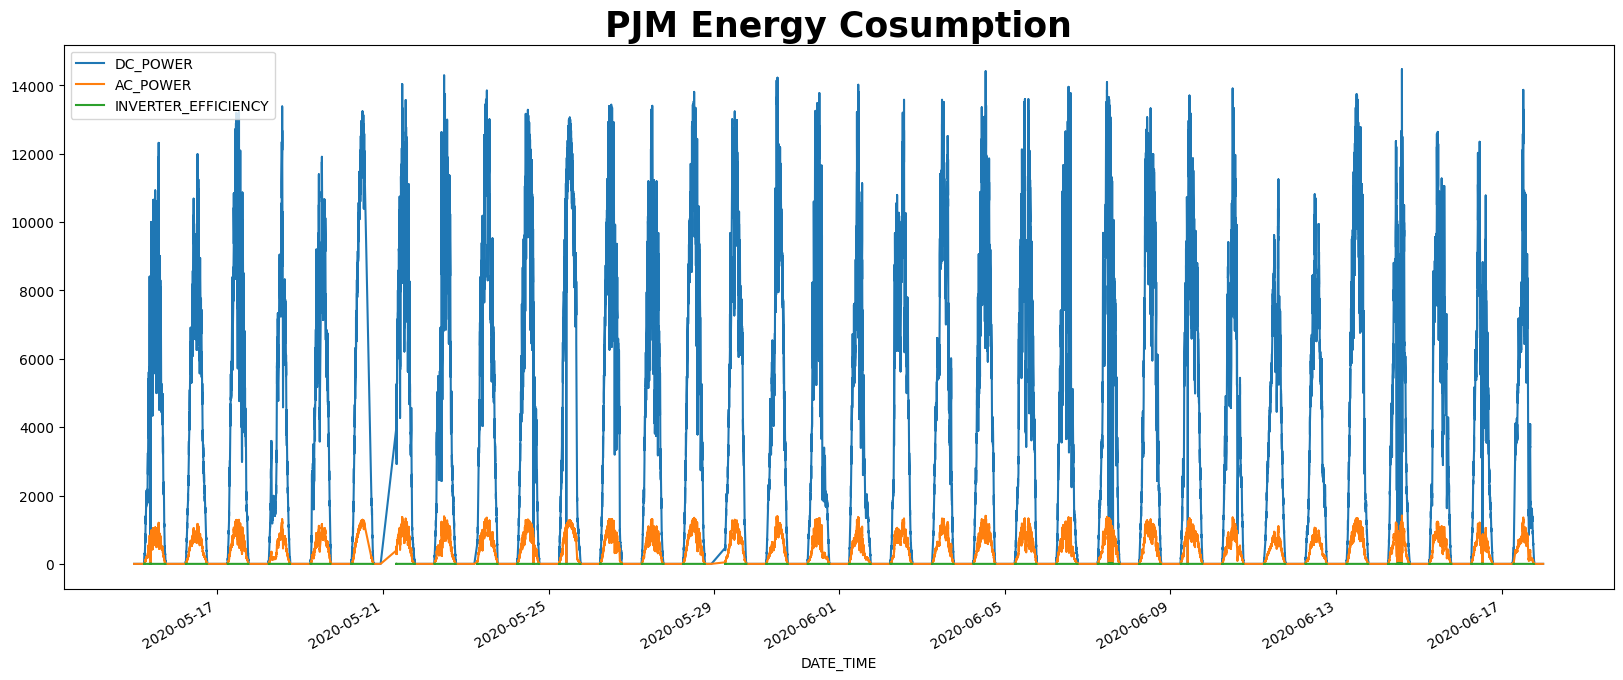

In [123]:
gen_1_ac_dc.plot(figsize=(20,8))
plt.title('PJM Energy Cosumption', weight='bold', fontsize=25)

In [124]:
gen_1_ac_dc.value_counts("SOURCE_KEY")

SOURCE_KEY
bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
VHMLBKoKgIrUVDU    3133
7JYdWkrLSPkdwr4    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
wCURE6d3bPkepu2    3126
z9Y9gH1T5YWrNuG    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
rGa61gmuvPhdLxV    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
adLQvlD726eNBSB    3119
1IF53ai7Xc0U56Y    3119
zBIq5rxdHJRwDNY    3119
3PZuoBAID5Wc2HD    3118
WRmjgnKYAwPKWDb    3118
YxYtjZvoooNbGkE    3104
Name: count, dtype: int64

In [125]:
gen_1_ac_dc.value_counts("DATE_TIME").sort_index

<bound method Series.sort_index of DATE_TIME
2020-06-17 23:45:00    22
2020-06-17 23:30:00    22
2020-06-17 23:15:00    22
2020-06-17 19:00:00    22
2020-06-17 18:45:00    22
                       ..
2020-05-27 18:45:00    10
2020-05-22 20:15:00    10
2020-05-26 19:00:00    10
2020-06-03 14:00:00     4
2020-05-25 05:30:00     4
Name: count, Length: 3158, dtype: int64>

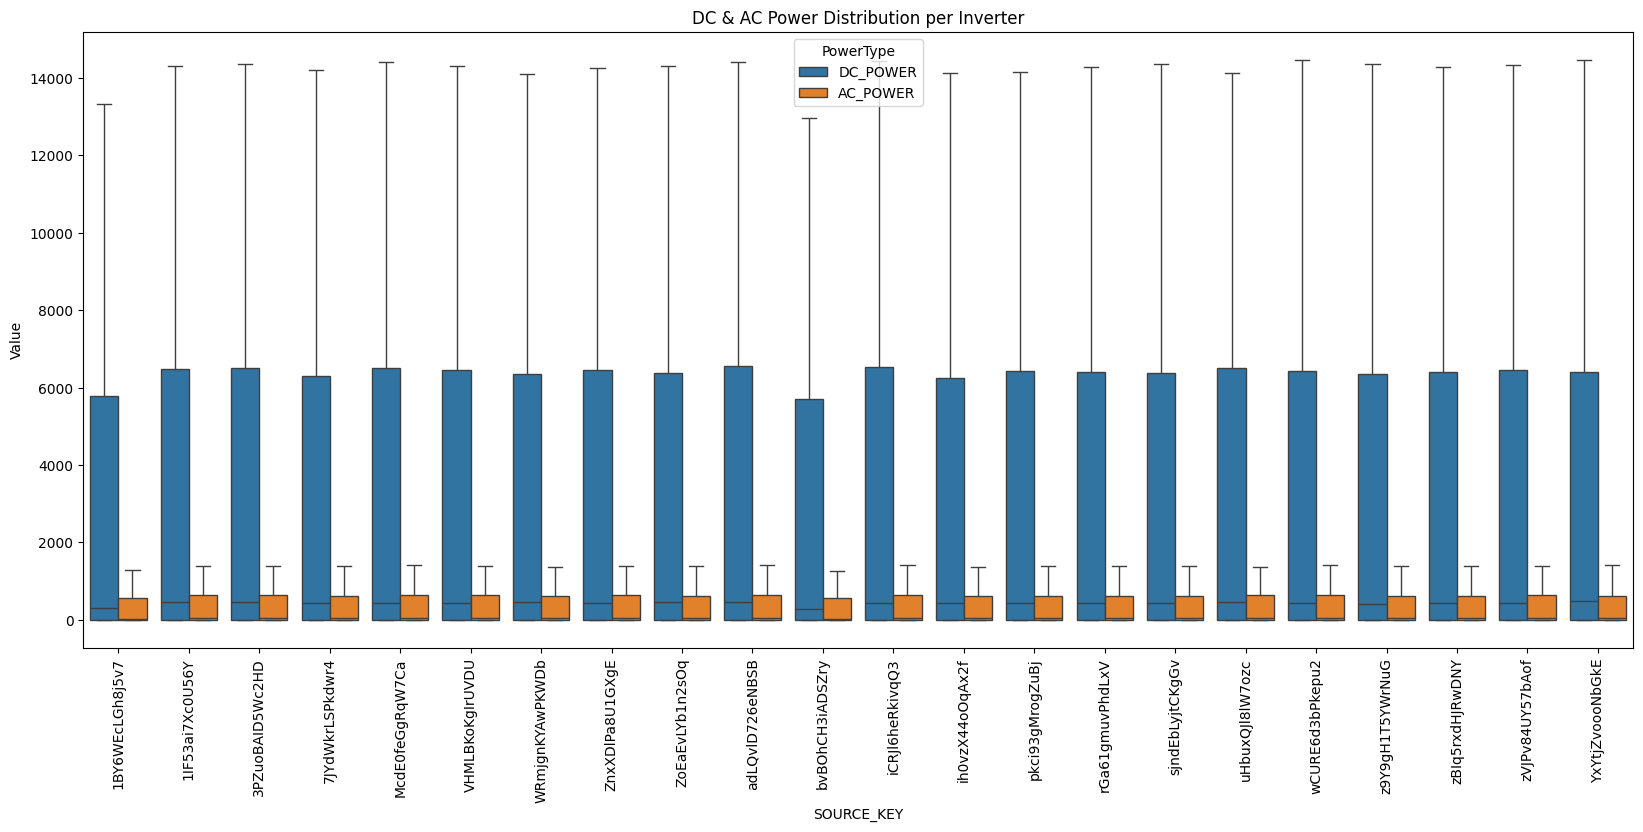

In [126]:
df_melt = gen_1_ac_dc.melt(
    id_vars="SOURCE_KEY",
    value_vars=["DC_POWER", "AC_POWER"],
    var_name="PowerType",
    value_name="Value"
)
plt.figure(figsize=(20, 8))
sns.boxplot(data=df_melt, x="SOURCE_KEY", y="Value", hue="PowerType")
plt.xticks(rotation=90)
plt.title("DC & AC Power Distribution per Inverter")
plt.show()

In [130]:
gen_1_pivot.head()

SOURCE_KEY,1BY6WEcLGh8j5v7,1IF53ai7Xc0U56Y,3PZuoBAID5Wc2HD,7JYdWkrLSPkdwr4,McdE0feGgRqW7Ca,VHMLBKoKgIrUVDU,WRmjgnKYAwPKWDb,YxYtjZvoooNbGkE,ZnxXDlPa8U1GXgE,ZoEaEvLYb1n2sOq,...,iCRJl6heRkivqQ3,ih0vzX44oOqAx2f,pkci93gMrogZuBj,rGa61gmuvPhdLxV,sjndEbLyjtCKgGv,uHbuxQJl8lW7ozc,wCURE6d3bPkepu2,z9Y9gH1T5YWrNuG,zBIq5rxdHJRwDNY,zVJPv84UY57bAof
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-05-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


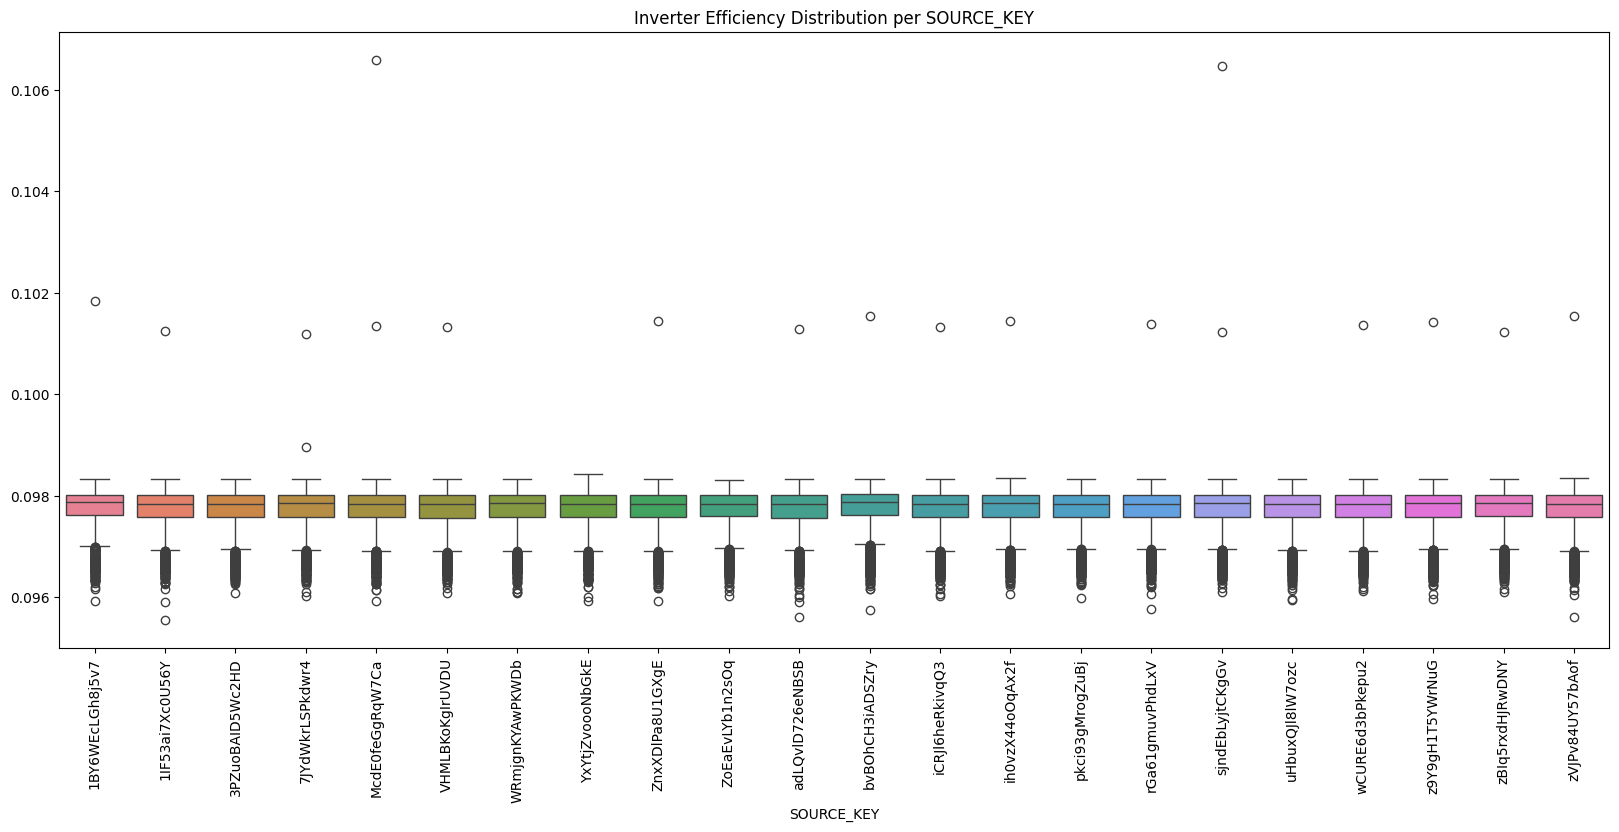

In [131]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=gen_1_pivot)
plt.xticks(rotation=90)
plt.title("Inverter Efficiency Distribution per SOURCE_KEY")
plt.show()

In [ ]:
gen_1_pivot['Hour'] = gen_1_pivot.index.hour
gen_1_pivot['Day'] = gen_1_pivot.index.day
gen_1_pivot.head(3)

SOURCE_KEY,1BY6WEcLGh8j5v7,1IF53ai7Xc0U56Y,3PZuoBAID5Wc2HD,7JYdWkrLSPkdwr4,McdE0feGgRqW7Ca,VHMLBKoKgIrUVDU,WRmjgnKYAwPKWDb,YxYtjZvoooNbGkE,ZnxXDlPa8U1GXgE,ZoEaEvLYb1n2sOq,...,pkci93gMrogZuBj,rGa61gmuvPhdLxV,sjndEbLyjtCKgGv,uHbuxQJl8lW7ozc,wCURE6d3bPkepu2,z9Y9gH1T5YWrNuG,zBIq5rxdHJRwDNY,zVJPv84UY57bAof,Hour,Day
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-05-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15
2020-05-15 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15
2020-05-15 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15


In [133]:
gen_1_pivot.columns

Index(['1BY6WEcLGh8j5v7', '1IF53ai7Xc0U56Y', '3PZuoBAID5Wc2HD',
       '7JYdWkrLSPkdwr4', 'McdE0feGgRqW7Ca', 'VHMLBKoKgIrUVDU',
       'WRmjgnKYAwPKWDb', 'YxYtjZvoooNbGkE', 'ZnxXDlPa8U1GXgE',
       'ZoEaEvLYb1n2sOq', 'adLQvlD726eNBSB', 'bvBOhCH3iADSZry',
       'iCRJl6heRkivqQ3', 'ih0vzX44oOqAx2f', 'pkci93gMrogZuBj',
       'rGa61gmuvPhdLxV', 'sjndEbLyjtCKgGv', 'uHbuxQJl8lW7ozc',
       'wCURE6d3bPkepu2', 'z9Y9gH1T5YWrNuG', 'zBIq5rxdHJRwDNY',
       'zVJPv84UY57bAof', 'Hour', 'Day'],
      dtype='object', name='SOURCE_KEY')

## 利用转换率每小时变化箱型图来判断可疑机器

Total inverters: 22


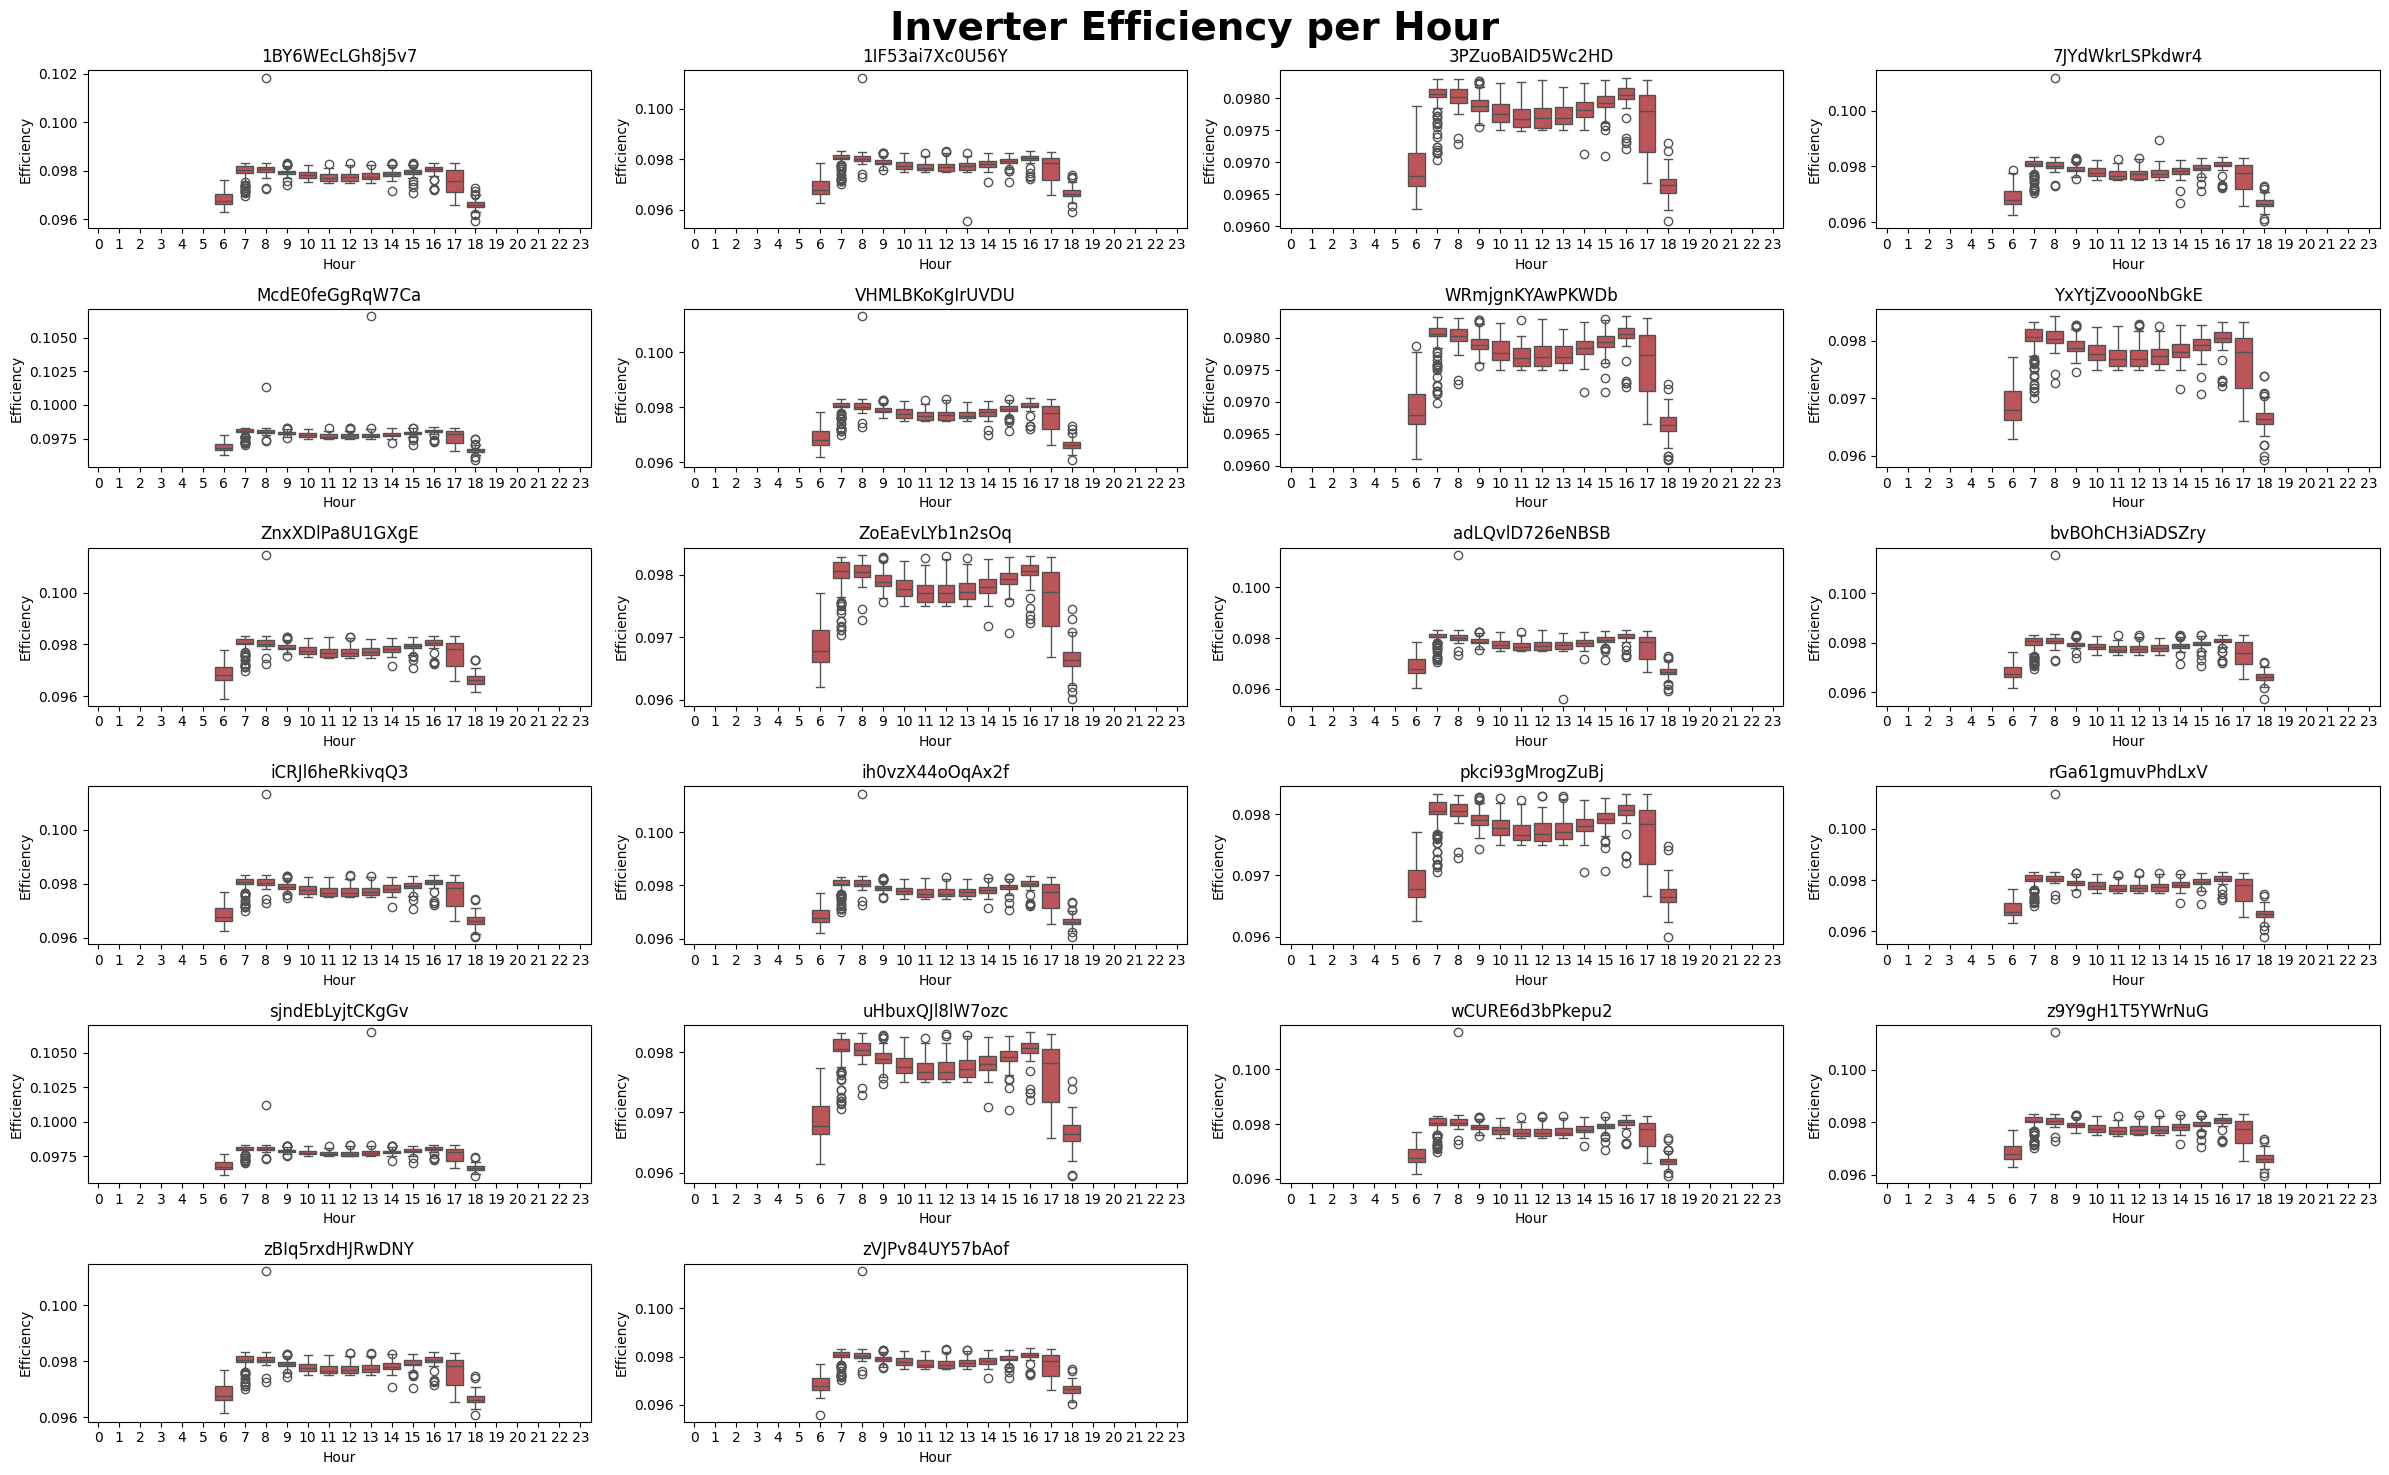

In [136]:
# 1. 提取逆变器列（排除 Hour, Day）
inverter_cols = [col for col in gen_1_pivot.columns if col not in ['Hour', 'Day']]

# 确认数量是 22
print("Total inverters:", len(inverter_cols))

# 2. 设置画布：6 行 × 4 列 = 24 格，够放 22 张
f, axes = plt.subplots(nrows=6, ncols=4, figsize=(24, 15))
f.suptitle('Inverter Efficiency per Hour', weight='bold', fontsize=28)

axes = axes.flatten()

# 3. 遍历每个逆变器，绘制子图
for i, col in enumerate(inverter_cols):
    sns.boxplot(
        data=gen_1_pivot,
        x=gen_1_pivot.index.hour,         # Hour on x-axis
        y=col,                            # inverter efficiency
        ax=axes[i],
        color='#cc444b'
    )
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_xlabel("Hour")
    axes[i].set_ylabel("Efficiency")

# 4. 删除多余的子图（最后两个）
for j in range(len(inverter_cols), len(axes)):
    f.delaxes(axes[j])

plt.tight_layout()
plt.show()
